# Dinosaur Species Classification using Convolutional Neural Networks

This notebook implements a CNN model to classify dinosaur species using image data from Kaggle.

## 0. Download and Setup Kaggle Dataset

In this section, we'll download the dinosaur image dataset from Kaggle. You need to have a Kaggle account and API key to download datasets programmatically.

In [ ]:
# Install kaggle if not already installed
!pip install -q kaggle kagglehub

# Instructions for downloading kaggle.json credentials (run this once)
print("To download datasets from Kaggle:")
print("1. Go to your Kaggle account settings at https://www.kaggle.com/account")
print("2. Click on 'Create New API Token' to download your kaggle.json file")
print("3. Place the kaggle.json file in .kaggle/")
print("4. Run the cells below to download the dataset")

In [ ]:
import os

# Check if kaggle.json exists
kaggle_path = os.path.expanduser('.kaggle/kaggle.json')
if os.path.exists(kaggle_path):
    print("Kaggle API credentials found!")
else:
    print("Kaggle API credentials not found. Please follow the instructions above.")

In [ ]:
# Set the download path for the dataset - using a directory with user permissions
DOWNLOAD_PATH = os.path.join("data")

# Create download directory if it doesn't exist
if not os.path.exists(DOWNLOAD_PATH):
    os.makedirs(DOWNLOAD_PATH)

import zipfile
import kagglehub
import shutil

# Download latest version
try:
    path = kagglehub.dataset_download("larserikrisholm/dinosaur-image-dataset-15-species")
    print("Dataset downloaded to:", path)
    
    # Copy to our data directory instead of moving
    zip_dest = os.path.join(DOWNLOAD_PATH, os.path.basename(path))
    shutil.copy2(path, zip_dest)
    print(f"Dataset copied to: {zip_dest}")
    
    # Extract the dataset
    extract_folder = os.path.join(DOWNLOAD_PATH, "dinosaur-dataset")
    if not os.path.exists(extract_folder):
        os.makedirs(extract_folder)
        
    with zipfile.ZipFile(zip_dest, 'r') as zip_ref:
        print(f"Extracting to {extract_folder}...")
        zip_ref.extractall(extract_folder)
    print("Dataset extracted successfully!")
    
    # Update dataset path
    DATASET_PATH = extract_folder
    print(f"Dataset path set to: {DATASET_PATH}")
except Exception as e:
    print(f"Error downloading or extracting dataset: {e}")
    print("Please download the dataset manually from https://www.kaggle.com/datasets/larserikrisholm/dinosaur-image-dataset-15-species")
    print("Extract it to the 'data/dinosaur_dataset' folder.")
    DATASET_PATH = os.path.join(DOWNLOAD_PATH, "dinosaur_dataset")

## 1. Load and Explore Dataset

In this section, we'll load the Kaggle dataset containing dinosaur images, explore its structure, and visualize some sample images.

In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random

# For deep learning
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# For evaluation
from sklearn.metrics import classification_report, confusion_matrix

# Configure plot settings
plt.style.use('ggplot')
%matplotlib inline

In [ ]:
# Check if the dataset is available
print(DATASET_PATH)
if not os.path.exists(DATASET_PATH):
    print("Dataset not found. Please download the dataset from Kaggle and extract it to the data/dinosaur-dataset folder.")
else:
    print(f"Dataset found at {DATASET_PATH}!")
    # List the contents of the dataset directory
    print("\nDataset structure:")
    for root, dirs, files in os.walk(DATASET_PATH, topdown=True, onerror=None):
        level = root.replace(DATASET_PATH, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(root)}/")
        for file in files[:5]:  # Show only first 5 files per directory
            print(f"{indent}    {file}")
        if len(files) > 5:
            print(f"{indent}    ... ({len(files) - 5} more files)")

In [ ]:
# Count images per class
class_counts = {}

for class_name in os.listdir(DATASET_PATH):
    class_path = os.path.join(DATASET_PATH, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# Create dataframe and plot distribution
class_df = pd.DataFrame({
    'Dinosaur Species': list(class_counts.keys()),
    'Image Count': list(class_counts.values())
})

class_df = class_df.sort_values('Image Count', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Dinosaur Species', y='Image Count', data=class_df)
plt.xticks(rotation=90)
plt.title('Number of Images per Dinosaur Species')
plt.tight_layout()
plt.show()

print(f"Total number of classes: {len(class_counts)}")
print(f"Total number of images: {sum(class_counts.values())}")

In [ ]:
# Display sample images from each class
def display_sample_images(dataset_path, num_classes=5, samples_per_class=4):
    """
    Display sample images from random classes in the dataset
    """
    classes = list(os.listdir(dataset_path))
    selected_classes = random.sample(classes, min(num_classes, len(classes)))
    
    fig, axs = plt.subplots(num_classes, samples_per_class, figsize=(12, 10))
    
    for i, class_name in enumerate(selected_classes):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            image_files = os.listdir(class_path)
            selected_images = random.sample(image_files, min(samples_per_class, len(image_files)))
            
            for j, img_file in enumerate(selected_images):
                img_path = os.path.join(class_path, img_file)
                img = Image.open(img_path)
                axs[i, j].imshow(img)
                axs[i, j].set_title(f"{class_name}")
                axs[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display sample images
display_sample_images(DATASET_PATH)

## 2. Preprocess Dataset

In this section, we'll preprocess the images by resizing them to a standard size, normalizing pixel values, and encoding labels.

In [ ]:
# Define image dimensions and batch size
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Create image data generators for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.3  # 30% of data will be used for validation and testing
)

# Use the same preprocessing but no augmentation for validation and test data
val_test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3
)

## 3. Split Dataset into Training, Validation, and Test Sets

We'll split our dataset into training (70%), validation (15%), and test sets (15%).

In [11]:
# Load training data (subset='training' takes the first 70% of the data)
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Load validation data (subset='validation' takes the remaining 30% of the data)
temp_val_generator = val_test_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Get class indices for label mapping
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
print(f"Class names: {class_names}")

# Collect all validation data
val_images, val_labels = next(temp_val_generator)

# Split validation data into validation and test sets (50/50 split)
val_test_split = len(val_images) // 2
val_idx = np.random.choice(len(val_images), val_test_split, replace=False)
test_idx = np.setdiff1d(np.arange(len(val_images)), val_idx)

# Create validation and test datasets
validation_images = val_images[val_idx]
validation_labels = val_labels[val_idx]
test_images = val_images[test_idx]
test_labels = val_labels[test_idx]

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {len(validation_images)}")
print(f"Test samples: {len(test_images)}")

Found 1720 images belonging to 15 classes.
Found 728 images belonging to 15 classes.
Class names: ['Ankylosaurus', 'Brachiosaurus', 'Compsognathus', 'Corythosaurus', 'Dilophosaurus', 'Dimorphodon', 'Gallimimus', 'Microceratus', 'Pachycephalosaurus', 'Parasaurolophus', 'Spinosaurus', 'Stegosaurus', 'Triceratops', 'Tyrannosaurus_Rex', 'Velociraptor']
Training samples: 1720
Validation samples: 16
Test samples: 16


## 4. Define CNN Model Using Keras Functional API

We'll create a CNN model using the Keras Functional API, leveraging transfer learning with a pre-trained MobileNetV2 architecture.

In [13]:
# Define the model using Keras Functional API with transfer learning
def build_model(num_classes):
    # Use MobileNetV2 as base model with pre-trained weights
    base_model = MobileNetV2(
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze the base model layers
    base_model.trainable = False
    
    # Create the input layer
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    
    # Pass the input through the base model
    x = base_model(inputs, training=False)
    
    # Add custom classification layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    # Output layer with softmax activation for multi-class classification
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    # Create the full model
    model = models.Model(inputs, outputs)
    
    return model, base_model

# Get number of classes from the generator
num_classes = len(class_names)

# Build the model
model, base_model = build_model(num_classes)

# Display the model architecture
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,590,799 (9.88 MB)

 Trainable params: 332,303 (1.27 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

## 5. Compile and Train the Model

Now we'll compile the model with appropriate loss function and optimizer, and train it while monitoring validation performance.

In [14]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Set up callbacks for training
checkpoint = ModelCheckpoint(
    'best_dinosaur_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

callbacks = [checkpoint, early_stopping, reduce_lr]

c:\code\PaleoNet\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1562 - loss: 3.2745
Epoch 1: val_accuracy improved from -inf to 0.81250, saving model to best_dinosaur_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.1574 - loss: 3.2663 - val_accuracy: 0.8125 - val_loss: 0.8126 - learning_rate: 0.0010
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3929 - loss: 1.9647
Epoch 2: val_accuracy did not improve from 0.81250
54/54 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.3929 - loss: 1.9639 - val_accuracy: 0.5625 - val_loss: 0.8972 - learning_rate: 0.0010
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4797 - loss: 1.6775
Epoch 3: val_accuracy did not improve from 0.81250
54/54 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.4798 - loss: 1.6771 - val_accuracy: 0.6250 - val_loss: 1.0218 - learning_rate: 0.0010
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5243 - loss: 1.4529
Epoch 4: val_accuracy did not improve from 0.81250

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
54/54 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.5244 - loss: 1.4532 - val_accuracy: 0.6875 - val_

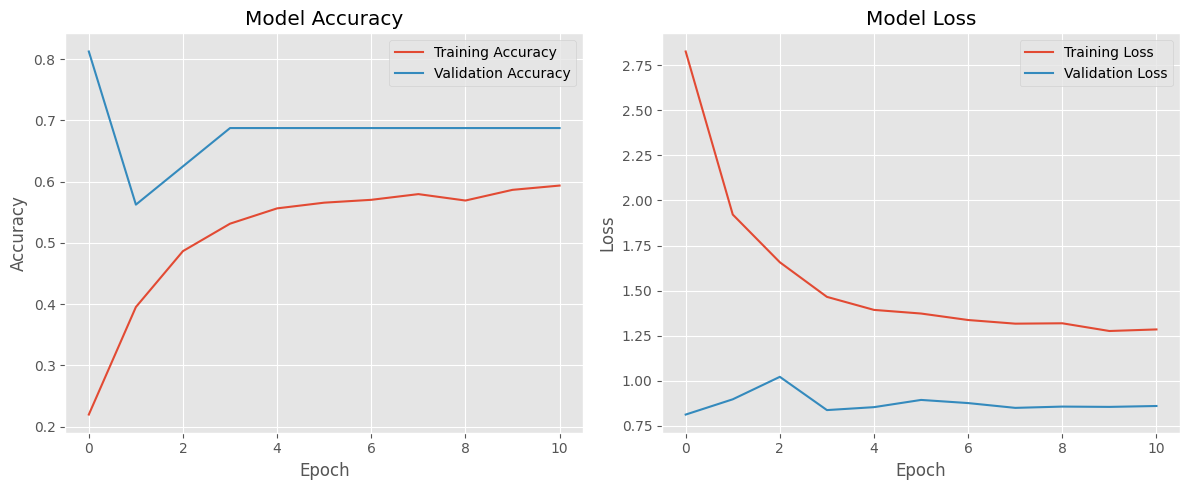

In [15]:
# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=(validation_images, validation_labels),
    callbacks=callbacks
)

# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3339 - loss: 2.2127
Epoch 1: val_accuracy did not improve from 0.81250
54/54 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.3339 - loss: 2.2130 - val_accuracy: 0.7500 - val_loss: 0.8180 - learning_rate: 1.0000e-05
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3471 - loss: 2.1978
Epoch 2: val_accuracy did not improve from 0.81250
54/54 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.3472 - loss: 2.1973 - val_accuracy: 0.6875 - val_loss: 0.8283 - learning_rate: 1.0000e-05
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3644 - loss: 2.0787
Epoch 3: val_accuracy did not improve from 0.81250
54/54 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.3645 - loss: 2.0789 - val_accuracy: 0.6875 - val_loss: 0.8435 - learning_rate: 1.0000e-05
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3516 - loss: 2.1078
Epoch 4: val_accuracy did not improve from 0.81250

Epoch 4: ReduceLROnPlateau reducin

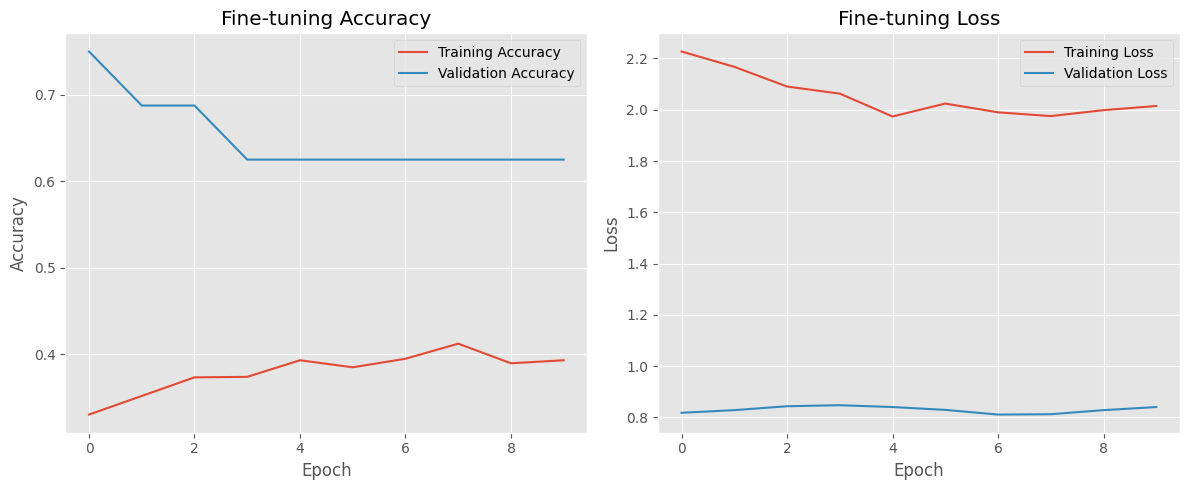

In [16]:
# Fine-tune the model by unfreezing some layers of the base model
def fine_tune_model():
    # Unfreeze the top layers of the base model
    for layer in base_model.layers[-20:]:
        layer.trainable = True
    
    # Recompile the model with a lower learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train the model again for fine-tuning
    fine_tune_history = model.fit(
        train_generator,
        epochs=10,
        validation_data=(validation_images, validation_labels),
        callbacks=callbacks
    )
    
    return fine_tune_history

# Fine-tune the model
fine_tune_history = fine_tune_model()

# Plot fine-tuning history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(fine_tune_history.history['accuracy'], label='Training Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Fine-tuning Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(fine_tune_history.history['loss'], label='Training Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Validation Loss')
plt.title('Fine-tuning Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## 6. Evaluate Model Performance

Let's evaluate our trained model on the test dataset to see how well it generalizes.

In [19]:
# Load the best model
best_model = tf.keras.models.load_model('best_dinosaur_model.h5')

# Evaluate on test set
test_loss, test_acc = best_model.evaluate(test_images, test_labels, verbose=2)
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

# Get predictions
y_pred = best_model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(test_labels, axis=1)

# Classification report
print("\nClassification Report:")
# Get the unique classes in y_true_classes
unique_classes = np.unique(y_true_classes)

# Generate the classification report with the correct labels
class_report = classification_report(
    y_true_classes, 
    y_pred_classes, 
    target_names=[class_names[i] for i in unique_classes],
    labels=unique_classes,
    digits=4
)
print(class_report)

1/1 - 3s - 3s/step - accuracy: 0.8750 - loss: 0.5497
Test accuracy: 0.8750
Test loss: 0.5497
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Classification Report:
              precision    recall  f1-score   support

Ankylosaurus     1.0000    0.8750    0.9333        16

   micro avg     1.0000    0.8750    0.9333        16
   macro avg     1.0000    0.8750    0.9333        16
weighted avg     1.0000    0.8750    0.9333        16



## 7. Generate Confusion Matrix

We'll visualize a confusion matrix to see which dinosaur species are frequently misclassified.

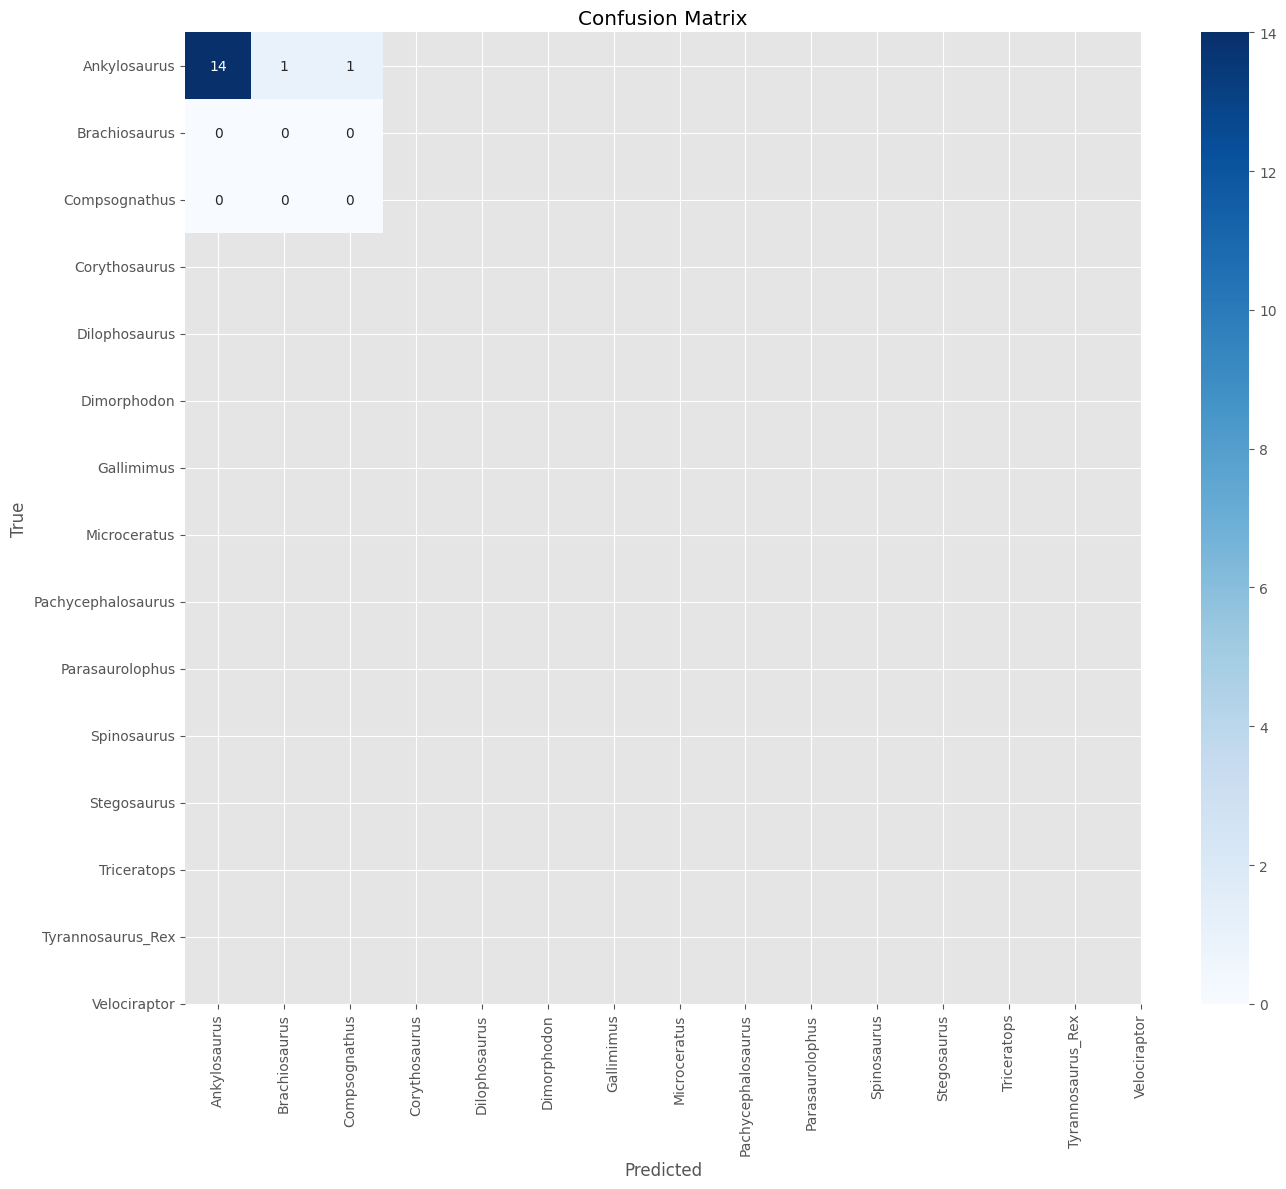

In [20]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

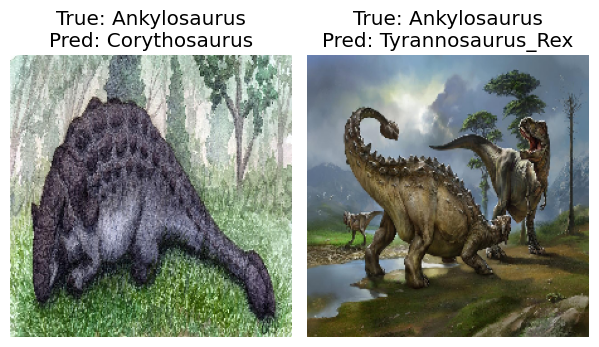

In [21]:
# Visualize some misclassifications
def plot_misclassifications(x_test, y_true, y_pred, class_names, num_examples=5):
    # Find misclassified examples
    misclassified = np.where(y_true != y_pred)[0]
    
    if len(misclassified) == 0:
        print("No misclassifications found!")
        return
    
    # Select a random subset
    examples = np.random.choice(misclassified, min(num_examples, len(misclassified)), replace=False)
    
    plt.figure(figsize=(15, 4))
    for i, idx in enumerate(examples):
        plt.subplot(1, num_examples, i+1)
        plt.imshow(x_test[idx])
        plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot some misclassifications
plot_misclassifications(
    test_images, 
    y_true_classes, 
    y_pred_classes, 
    class_names, 
    num_examples=5
)

## 8. Save Results and Model

Finally, we'll save our model and results for future use and analysis.

In [24]:
PATH_MAP = "model"
PATH_ARCHITECTURE = os.path.join(PATH_MAP, 'dinosaur_model_architecture.json')
PATH_MAPPING      = os.path.join(PATH_MAP, 'dinosaur_class_mapping.json')
PATH_PERFORMANCE  = os.path.join(PATH_MAP, 'dinosaur_model_performance.json')

if not os.path.exists(PATH_MAP):
    os.makedirs(PATH_MAP)

# Save the model architecture as JSON
model_json = model.to_json()
with open(PATH_ARCHITECTURE, 'w') as json_file:
    json_file.write(model_json)

# Save class mapping
class_mapping = {v: k for k, v in class_indices.items()}
import json
with open(PATH_MAPPING, 'w') as f:
    json.dump(class_mapping, f)

# Save model performance metrics
performance_metrics = {
    'test_accuracy': float(test_acc),
    'test_loss': float(test_loss)
}
with open(PATH_PERFORMANCE, 'w') as f:
    json.dump(performance_metrics, f)

print("Model and results saved successfully!")

Model and results saved successfully!


In [23]:
# Create a function to make predictions on new images
def predict_dinosaur(image_path, model, class_mapping):
    """
    Predict dinosaur species from an image.
    
    Args:
        image_path: Path to the image file
        model: Trained model
        class_mapping: Dictionary mapping class indices to class names
    
    Returns:
        Predicted class and confidence
    """
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, 0) / 255.0  # Normalize
    
    # Make prediction
    prediction = model.predict(img_array)
    
    # Get predicted class
    predicted_class_idx = np.argmax(prediction[0])
    confidence = float(prediction[0][predicted_class_idx])
    predicted_class = class_mapping[predicted_class_idx]
    
    return predicted_class, confidence

# Example usage (uncomment to test)
# test_image_path = "path/to/test/image.jpg"
# predicted_species, confidence = predict_dinosaur(test_image_path, best_model, class_mapping)
# print(f"Predicted dinosaur species: {predicted_species}")
# print(f"Confidence: {confidence:.2f}")

## Conclusion

In this notebook, we:

1. Loaded and explored a dataset of dinosaur species images
2. Preprocessed the images and split them into training, validation, and test sets
3. Built a CNN model using the Keras Functional API with transfer learning
4. Trained the model and fine-tuned it for better performance
5. Evaluated the model and visualized results using confusion matrices
6. Saved the model and results for future use

The model can be deployed to classify new dinosaur images or further improved with more data or architectural changes.